# **Load data and install modules**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install stable-baselines3[extra] --quiet
!pip install tensorboard --quiet

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque

In [4]:
path = '/content/drive/MyDrive/Wisdomise/'

df_train = pd.read_csv(path + 'df_with_features_train.csv')
df_test = pd.read_csv(path + 'df_with_features_test.csv')

unwanted_columns = [x for x in df_train.columns if 'Unnamed' in x]
df_train.drop(columns=unwanted_columns, inplace=True)
df_test.drop(columns=unwanted_columns, inplace=True)

In [5]:
assets = ['usdt'] + ['btc', 'eth', 'xrp', 'ftm']  # add 'usdt' (i.e., chash) for consistency

features_list = df_train.columns[(1+5*len(assets[1:])):]

print(f'Total {len(features_list)} features are : \n\n {features_list.values}')

Total 26 features are : 

 ['btc_week_to_month_ratio' 'eth_week_to_month_ratio'
 'xrp_week_to_month_ratio' 'ftm_week_to_month_ratio'
 'btc_three_days_to_week_ratio' 'eth_three_days_to_week_ratio'
 'xrp_three_days_to_week_ratio' 'ftm_three_days_to_week_ratio'
 'btc_binned_entropy_month' 'eth_binned_entropy_month'
 'xrp_binned_entropy_month' 'ftm_binned_entropy_month' 'btc_two_weeks_rsi'
 'eth_two_weeks_rsi' 'xrp_two_weeks_rsi' 'ftm_two_weeks_rsi'
 'btc_month_cmf' 'eth_month_cmf' 'xrp_month_cmf' 'ftm_month_cmf'
 'eth_corr_with_btc_month' 'xrp_corr_with_btc_month'
 'ftm_corr_with_btc_month' 'eth_corr_with_btc_week'
 'xrp_corr_with_btc_week' 'ftm_corr_with_btc_week']


# **Define Environment**


In [6]:
from gym import Env, spaces


class Environment(Env):
    """all methods related to the market environment
    trading functions source: FinRL (https://github.com/AI4Finance-Foundation/FinRL)
     """

    def __init__(self, dataset, features_list, assets, initial_cash=1000,
                 sell_cost_pct=0.015, buy_cost_pct=0.015):
        super(Environment, self).__init__()

        # constants
        self.DATASET = dataset
        self.FEATURES_LIST = features_list
        self.NUMBER_OF_FEATURES = len(self.FEATURES_LIST)
        self.INITIAL_CASH = initial_cash
        self.ASSETS = assets
        self.NUMBER_OF_ASSETS = len(self.ASSETS)  # including 'usdt' as an asset
        self.SELL_COST_PCT = sell_cost_pct
        self.BUY_COST_PCT = buy_cost_pct
        self.EPISODE_LEN = len(self.DATASET.index.unique()) - 1

        # workflow variables
        self.capitals = dict(zip(self.ASSETS, np.zeros(len(self.ASSETS))))
        self.capitals['usdt'] = self.INITIAL_CASH

        self.ctr = 0

        # instantiate observation and action spaces
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.NUMBER_OF_FEATURES + self.NUMBER_OF_ASSETS,), 
                                            dtype=np.float32)

        # actions are in the interval [1-, +1] for all assets except cash
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.NUMBER_OF_ASSETS - 1,),
                                       dtype=np.float32)

        # instantiate observation vecor
        self.observations = self._make_observation().astype(np.float32)

        # logging variables
        self.actions_list = np.full((self.EPISODE_LEN + 1, self.NUMBER_OF_ASSETS - 1), np.nan)
        self.rewards_list = np.full(self.EPISODE_LEN + 1, np.nan)
        self.total_capital_list = np.full(self.EPISODE_LEN + 1, np.nan)
        self.total_capital_list[0] = self.INITIAL_CASH

    def step(self, actions):

        self._do_trades(actions)

        self.ctr += 1
        reward = self._calculate_rewards()

        self._update_state(actions, reward)

        done = self._is_end_of_episode()

        return self.observations, reward, done, {}

    def reset(self):

        # reset counter
        self.ctr = 0

        # instantiate observation vecor
        self.observations = self._make_observation().astype(np.float32)

        # workflow variables
        self.capitals = dict(zip(self.ASSETS, np.zeros(len(self.ASSETS))))
        self.capitals['usdt'] = self.INITIAL_CASH

        return self.observations

    def _do_trades(self, actions):

        # first sell assets (negative actions)
        for i, action in enumerate(actions):
            if -1 <= action < 0:  # buy the asset
                self._sell_asset(self.ASSETS[i + 1], actions[i])

        actions = np.where(np.array(actions) > 0, actions, 0)
        our_cash_for_each_asset = self.capitals['usdt'] * actions / sum(actions)

        # then buy assets (positive actions)
        for i, action in enumerate(actions):
            if 0 < action <= 1:  # buy the asset
                self._buy_asset(self.ASSETS[i + 1], actions[i], our_cash_for_each_asset[i])

    def _get_last_price(self, asset_id):
        return self.DATASET['close_'+asset_id].iloc[self.ctr]

    def _sell_asset(self, asset_id: str, action: float):
        # negative action value is used for selling
        assert -1 <= action < 0

        price = self._get_last_price(asset_id)
        our_capacity = self.capitals[asset_id]

        sell_num_shares = abs(action * our_capacity)
        sell_amount = price * sell_num_shares * (1 - self.SELL_COST_PCT)  # per $

        self.capitals['usdt'] += sell_amount
        self.capitals[asset_id] -= sell_num_shares

    def _buy_asset(self, asset_id: str, action: float, our_cash: float):
        # positive action value is used for buying
        assert 0 < action <= 1

        price = self._get_last_price(asset_id)

        buy_num_shares = (action * our_cash) / (price * (1 + self.BUY_COST_PCT))
        buy_amount = price * buy_num_shares * (1 + self.BUY_COST_PCT)  # per $

        self.capitals['usdt'] -= buy_amount
        self.capitals[asset_id] += buy_num_shares
        return buy_num_shares, buy_amount

    def _update_state(self, actions, reward):

        self.observations = self._make_observation()

        self.actions_list[self.ctr - 1, :] = actions
        self.rewards_list[self.ctr - 1] = reward
        self.total_capital_list[self.ctr] = sum(self._calculate_capitals_value())

    def _make_observation(self):
        ratio_of_assets = list(self._calculate_capitals_value() / sum(self._calculate_capitals_value()))
        features = list(self.DATASET.loc[self.ctr, self.FEATURES_LIST].values)
        return np.array(ratio_of_assets + features)

    def _calculate_capitals_value(self):
      return [self.capitals['usdt']] + [self.capitals[x] * self._get_last_price(x) for x in self.ASSETS[1:]]

    def _calculate_rewards(self):
        return (sum(self._calculate_capitals_value()) - self.total_capital_list[self.ctr-1]) \
         / self.total_capital_list[self.ctr-1]

    def _is_end_of_episode(self):
        return self.ctr >= self.EPISODE_LEN


# **Run Backtest**

In [ ]:
from stable_baselines3 import PPO

policy_networks = [dict(net_arch=[dict(pi=[8, 8], vf=[8, 8])]),
                   dict(net_arch=[dict(pi=[16, 8], vf=[16, 8])]),
                   dict(net_arch=[dict(pi=[32, 16], vf=[32, 16])]),
                   dict(net_arch=[dict(pi=[64, 16], vf=[64, 16])]),
                   dict(net_arch=[dict(pi=[128, 16], vf=[128, 16])]),
                   dict(net_arch=[dict(pi=[64, 8], vf=[64, 8])]),
                   dict(net_arch=[dict(pi=[128, 8], vf=[128, 8])])]

num_experiments = len(policy_networks)
num_episodes = 10
results_ppo_hparam_optimization = pd.DataFrame()

for i in range(num_experiments):

    # create environment for train
    env_train = Environment(df_train, features_list=features_list, assets=assets)

    policy_kwargs = policy_networks[i]

    agent = PPO("MlpPolicy", env_train, verbose=1,  policy_kwargs=policy_kwargs, tensorboard_log=None)
    agent.learn(total_timesteps=len(df_train)*num_episodes)

    # create environment for test
    env_test = Environment(df_test, features_list=features_list, assets=assets)

    obs = env_test.reset()
    done = False
    this_round_result = []
    this_round_result.append(env_test.total_capital_list[env_test.ctr])

    while not done:
        action, _ = agent.predict(obs.astype(np.float32), deterministic=True)
        obs, reward, done, _ = env_test.step(action)
        this_round_result.append(env_test.total_capital_list[env_test.ctr])
        if done:
            obs = env_test.reset()

    env_train.close(), env_test.close()
    del agent

    results_ppo_hparam_optimization[i] = this_round_result

In [8]:
best_index = results_ppo_hparam_optimization.iloc[-1, :len(assets)-1].values.argmax()
print(f'the best result is for {policy_networks[best_index]}')

the best result is for {'net_arch': [{'pi': [64, 16], 'vf': [64, 16]}]}


In [9]:
# repeat the testing with best network

num_experiments = 10
num_episodes = 10
results_ppo = pd.DataFrame()

# create environment for train
env_train = Environment(df_train, features_list=features_list, assets=assets)

policy_kwargs = policy_networks[best_index]

agent = PPO("MlpPolicy", env_train, verbose=1,  policy_kwargs=policy_kwargs, tensorboard_log="/ppo/")

agent.learn(total_timesteps=len(df_train)*num_episodes)

for i in range(num_experiments):

    # create environment for test
    env_test = Environment(df_test, features_list=features_list, assets=assets)

    obs = env_test.reset()
    done = False
    this_round_result = []
    this_round_result.append(env_test.total_capital_list[env_test.ctr])

    while not done:
        action, _ = agent.predict(obs.astype(np.float32), deterministic=True)
        obs, reward, done, _ = env_test.step(action)
        this_round_result.append(env_test.total_capital_list[env_test.ctr])
        if done:
            obs = env_test.reset()

    results_ppo[i] = this_round_result

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to /ppo/PPO_3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.06e+03 |
|    ep_rew_mean     | -6.14    |
| time/              |          |
|    fps             | 176      |
|    iterations      | 1        |
|    time_elapsed    | 11       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.06e+03     |
|    ep_rew_mean          | -5.3         |
| time/                   |              |
|    fps                  | 135          |
|    iterations           | 2            |
|    time_elapsed         | 30           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0060626287 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.67        |
|    explained_variance   | -0.687       |
|    learning_r

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/ppo'

In [12]:
results_ppo['date'] = df_test.date

results_ppo['ppo_avg'] = results_ppo.mean(axis=1)
results_ppo['ppo_std'] = results_ppo.std(axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


# **Benchmarking**

In [13]:
def manual_evaluate(env, action):
  while True:
    observation, reward, done, info = env.step(action)
    if done:
        break
  return env.total_capital_list

In [14]:
strategies = {
  'btc': [1, 0, 0, 0],
  'eth': [0, 1, 0, 0],
  'xrp': [0, 0, 1, 0],
  'ftm': [0, 0, 0, 1],
  'equal_buy_actions': [0.25, 0.25, 0.25, 0.25]
}

results_benchmark = pd.DataFrame(data=np.full((len(df_test), len(strategies.keys())), np.nan), columns=strategies.keys())
results_benchmark['date'] = df_test.date

for x in strategies.keys():
  env = Environment(df_test, features_list=features_list, assets=assets)
  total_capital_list = manual_evaluate(env, strategies[x])
  results_benchmark[x] = total_capital_list

# **Visualize results**

In [15]:
total_results = pd.merge(left=results_ppo[['date', 'ppo_avg', 'ppo_std']], right=results_benchmark, how='outer', on='date')

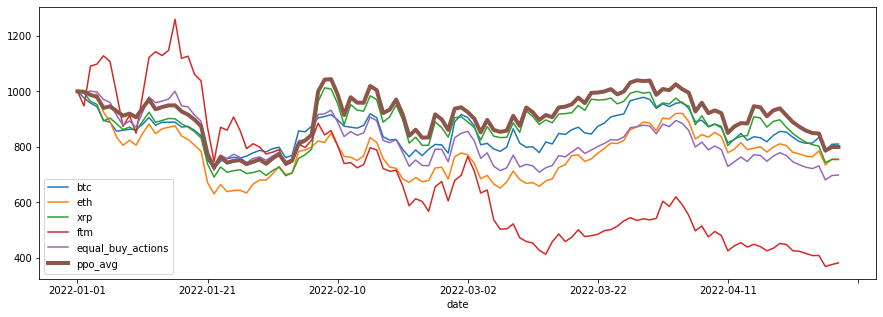

In [16]:
ax = total_results.plot(x='date', y=list(strategies.keys()), figsize=(15,5))
total_results.plot(x='date', y=['ppo_avg'], figsize=(15,5), lw=4, ax=ax)
plt.fill_between(total_results['date'],
                 total_results['ppo_avg'] - total_results['ppo_std'],
                 total_results['ppo_avg'] + total_results['ppo_std'],
                 color='gray', alpha=0.2)


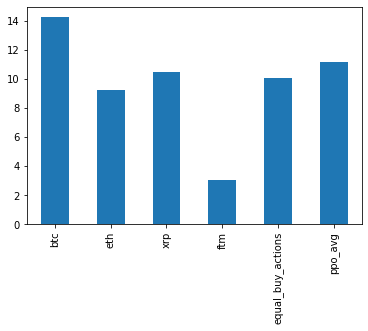

In [17]:
def sharpe(ls):
  return np.mean(ls) / np.std(ls)

sharpe(total_results[list(strategies.keys()) + ['ppo_avg']]).plot.bar()